In [4]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from EMQST_lib import visualization as vis
from EMQST_lib import overlapping_tomography as ot
import time
from EMQST_lib import support_functions as sf
plt.rcParams.update({'font.size': 15})

### Plot random Pauli averaging 

100


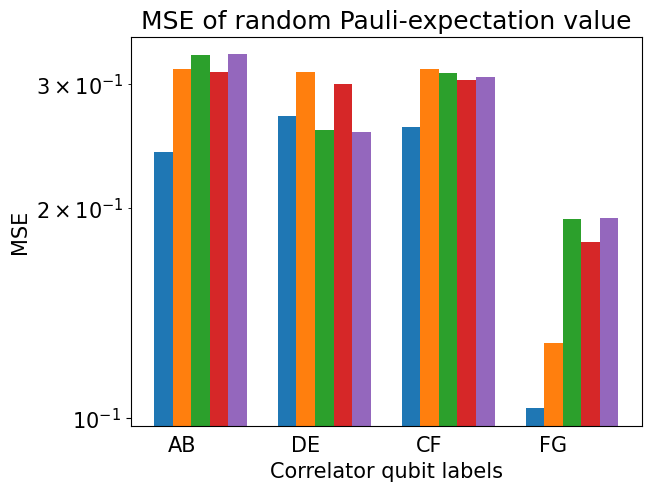

In [5]:
# Plotting random correlator result
data_path = "QDOT_results/2024-07-30_09-17-29_6a4707ca-4683-4d37-9e47-a6692025ba10"

n_samples = 9
n_qubits = 2

with open(f'{data_path}/result_QST.npy', 'rb') as f:
    result_dict =  np.load(f, allow_pickle=True).item()


true_rho_average_array = result_dict['true_rho_average_array']
state_reduction_rho_average_array = result_dict['state_reduction_rho_average_array']
two_RDM_QREM_rho_average_array = result_dict['two_RDM_QREM_rho_average_array']
no_QREM_rho_average_array = result_dict['no_QREM_rho_average_array']
povm_reduction_rho_average_array = result_dict['povm_reduction_rho_average_array']
factorized_QREM_rho_average_array = result_dict['factorized_QREM_rho_average_array']
classical_cluster_QREM_rho_average_array = result_dict['classical_cluster_QREM_rho_average_array']
two_point_corr_labels   = result_dict['two_point_corr_labels']

print(len(true_rho_average_array[0]))
def factorized_state_list_to_correlator_states(two_point_corr_labels, factorized_state_list, n_qubits):
    """
    Function converts a list of factorized states to a list of correlator states.
    """
    correlator_states = []
    for j in range(len(factorized_state_list)):
        correlator_states.append([])
        for i in range(len(two_point_corr_labels)):
            subsystem_index = ot.qubit_label_to_list_index(np.sort(two_point_corr_labels[i])[::-1], n_qubits) 
            qubit_sublist = factorized_state_list[j][subsystem_index]
            correlator_states[j].append(reduce(np.kron, qubit_sublist))
    return correlator_states

true_state_list = factorized_state_list_to_correlator_states(two_point_corr_labels, true_rho_average_array,12)
def generate_random_pauli_string(n_samples,n_qubits):
    """
    Function generates a random Pauli string of length n_elements.
    """
    pauli_1 = np.eye(2)
    pauli_x = np.array([[0,1],[1,0]])
    pauli_y = np.array([[0,-1j],[1j,0]])
    pauli_z = np.array([[1,0],[0,-1]])
    pauli_operators = np.array([pauli_1,pauli_x, pauli_y, pauli_z])
    pauli_string = np.random.randint(0,4,n_samples*n_qubits).reshape(n_samples,n_qubits)
    op_list = pauli_operators.take(pauli_string,axis = 0)  
    return np.array([reduce(np.kron, op_list[i]) for i in range(n_samples)]) 



def compute_exp_value(rho_average_array,pauli_string):
    """
    Function computes the expectation value of a Pauli string for a given state array.
    """

    return np.einsum('nijk,lkj->nil', rho_average_array, pauli_string).real

def compute_MSE(true_exp_value, exp_value):
    """
    Function computes the mean squared error between two sets of density matrices.
    """
    return np.mean((true_exp_value - exp_value)**2,axis = (0,2))

op_string = generate_random_pauli_string(n_samples,n_qubits)
true_exp_value = compute_exp_value(true_state_list,op_string)

no_QREM_exp_value = compute_exp_value(no_QREM_rho_average_array,op_string)
state_reduction_exp_value = compute_exp_value(state_reduction_rho_average_array,op_string)
two_RDM_QREM_exp_value = compute_exp_value(two_RDM_QREM_rho_average_array,op_string)
#povm_reduction_exp_value = compute_exp_value(povm_reduction_rho_average_array,op_string)
factorized_QREM_exp_value = compute_exp_value(factorized_QREM_rho_average_array,op_string)
classical_cluster_QREM_exp_value = compute_exp_value(classical_cluster_QREM_rho_average_array,op_string)


no_QREM_MSE = compute_MSE(true_exp_value, no_QREM_exp_value)
classical_cluster_QREM_MSE = compute_MSE(true_exp_value, classical_cluster_QREM_exp_value)
facotrized_QREM_MSE = compute_MSE(true_exp_value, factorized_QREM_exp_value)
two_RDM_exp_MSE = compute_MSE(true_exp_value, two_RDM_QREM_exp_value)
state_reduction_MSE = compute_MSE(true_exp_value, state_reduction_exp_value)

legends = ['AB','DE','CF','FG']
data = {'No QREM':no_QREM_MSE[::-1],
        'Factorized QREM':facotrized_QREM_MSE[::-1],
        '2-point correlator QREM':two_RDM_exp_MSE[::-1],
        'Classical cluster QREM': classical_cluster_QREM_MSE[::-1],
        'State reduction cluster QREM': state_reduction_MSE[::-1]}
#x = np.arange(len(two_point_corr_labels))
#x = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels][:cutoff]

x = np.arange(len(legends))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1
ax.set_yscale('log')
ax.set_title(f"MSE of random Pauli-expectation value")

ax.set_xticks(x + width, legends)

plt.ylabel('MSE')
plt.xlabel('Correlator qubit labels')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plt.text(10, 0.3, text_string, fontsize=14,verticalalignment='top', bbox=props)


### Infidelity comparison plot

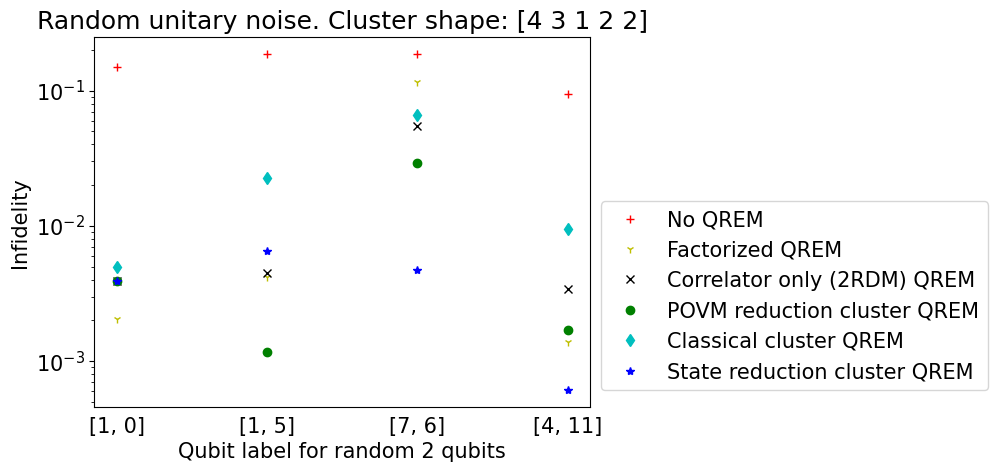

In [6]:

data_path = "QDOT_results/2024-08-01_13-23-06_9debe732-8fc3-49b5-bdde-ef8b208d43b5"
with open(f'{data_path}/result_inf.npy', 'rb') as f:
    result_dict =  np.load(f, allow_pickle=True).item()

averaged_classical_cluster_QREM_inf_array = result_dict['averaged_classical_cluster_QREM_inf_array']
averaged_factorized_QREM_inf_array = result_dict['averaged_factorized_QREM_inf_array']
averaged_no_QREM_inf_array = result_dict['averaged_no_QREM_inf_array']
averaged_povm_reduction_inf_array = result_dict['averaged_povm_reduction_inf_array']
averaged_two_RDM_QREM_inf_array = result_dict['averaged_two_RDM_QREM_inf_array']
averaged_state_reduction_inf_array = result_dict['averaged_state_reduction_inf_array']




no_QREM_inf_array = result_dict['no_QREM_inf_array']
factorized_QREM_inf_array = result_dict['factorized_QREM_inf_array']
two_RDM_QREM_inf_array = result_dict['two_RDM_QREM_inf_array']
povm_reduction_inf_array = result_dict['povm_reduction_inf_array']
classical_cluster_QREM_inf_array = result_dict['classical_cluster_QREM_inf_array']
state_reduction_inf_array = result_dict['state_reduction_inf_array']

cluster_size = result_dict["cluster_size"]
noise_mode = result_dict["noise_mode"]
n_clusters = len(cluster_size)
it = 0
cluster_plotting_list = []
for i in range(n_clusters): # To print out the labels that are related. 
    cluster_plotting_list.append(list(ot.qubit_label_to_list_index(np.arange(it, it + cluster_size[i]),sum(cluster_size))))
    it+=cluster_size[i]


text_string = 'Cluster label structure:\n'
for i, cluster in enumerate(cluster_plotting_list):
    text_string += f'Cluster {i}: {cluster}\n'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

noise_titles = ['Depolarizing noise',"Random unitary noise", 'Random strenght 2 qubit unitary noise']

x = np.arange(len(two_point_corr_labels))
x = [f'[{label[0]}, {label[1]}]' for label in two_point_corr_labels]
plt.title(f"{noise_titles[noise_mode-1]}. Cluster shape: {cluster_size}")
plt.plot(x, averaged_no_QREM_inf_array, 'r+', label = 'No QREM')
plt.plot(x, averaged_factorized_QREM_inf_array, 'y1', label = 'Factorized QREM')
plt.plot(x, averaged_two_RDM_QREM_inf_array,  'kx',label = 'Correlator only (2RDM) QREM')
plt.plot(x, averaged_povm_reduction_inf_array, 'go', label = 'POVM reduction cluster QREM')
plt.plot(x, averaged_classical_cluster_QREM_inf_array, 'cd', label = 'Classical cluster QREM')
plt.plot(x, averaged_state_reduction_inf_array, 'b*', label = 'State reduction cluster QREM')

transparency = 0
for i in range(len(no_QREM_inf_array)):
    plt.plot(x, no_QREM_inf_array[i], 'r+', alpha = transparency)
    plt.plot(x, factorized_QREM_inf_array[i], 'y1', alpha = transparency)
    plt.plot(x, two_RDM_QREM_inf_array[i], 'kx', alpha = transparency)
    plt.plot(x, povm_reduction_inf_array[i], 'go', alpha = transparency)
    plt.plot(x, classical_cluster_QREM_inf_array[i], 'cd', alpha = transparency)
    plt.plot(x, state_reduction_inf_array[i], 'b*', alpha = transparency)



plt.yscale('log')
plt.ylabel('Infidelity')
plt.xlabel('Qubit label for random 2 qubits')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(loc='center left', bbox_to_anchor=(1, 0.3))

#plt.text(10, 0.3, text_string, fontsize=14,
#        verticalalignment='top', bbox=props)



### Runtime/scaling visualization

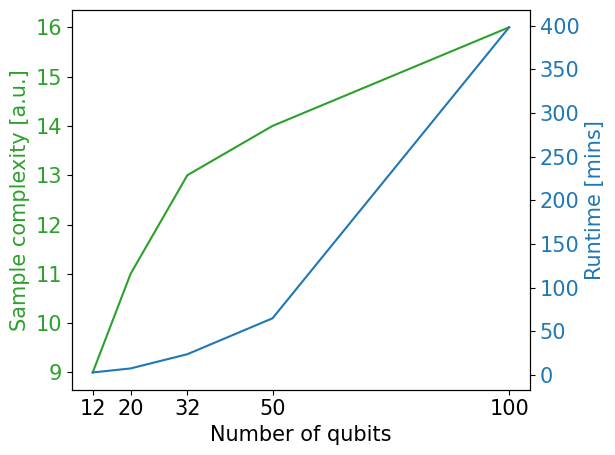

In [ ]:
# Create some mock data
n_qubits = [12, 20,32,50,100]
sample_complexity = np.array([9,11,13,14,16])#np.join(([1,2,3],[])))
comp_runtime = [3,7.6,23.9,65,398]

fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('Number of qubits')
ax1.set_ylabel(r'Sample complexity [a.u.]',color=color)
ax1.plot(n_qubits, sample_complexity,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set(xticks=n_qubits)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Runtime [mins]', color=color)  # we already handled the x-label with ax1
ax2.plot(n_qubits, comp_runtime, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
